<a href="https://colab.research.google.com/github/BQ-QB/Epidemic-Containment-Strategy-Modell/blob/main/sir_colab_dynamic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Hej och välkommen till en SIR-baserad simulerad pandemi, där ett neuralt nätverk försöker begränsa smittspridningen!

För att köra programmet så behöver nästan alla kodblock nedan köras en gång först, för att initialisera programmet. Kör dem i ordning, och stanna vid nästa textblock. Nedanför nästa textblock så kan du välja hur du vill köra programmet; med standardvärden på parametrar definierade av oss, eller med värden du skriver in själv. Du kan antingen skriva in dem som svar på frågor av programmet, eller ändra på ett kodblock.

#Programbeskrivning: 

I simuleringen finns det agenter. Dessa agenter kan befinna sig i olika tillstånd: mottaglig för sjukdom, sjuk, återhämtad från sjukdom, samt död. 

I simuleringen kan endast ett visst antal tester genomföras per tidssteg, för att efterlikna verklighetens begränsade resurser inom sjukvården.  

Vid starten av programmet placeras agenterna ut slumpmässigt. Vissa av dessa är vid starttillfället sjuka. Agenterna kan röra sig som på ett rutnät, som mest ett steg i sidled och ett steg i vertikal riktning. Agenterna kan dock inte röra sig allt för långt ifrån sin startposition, för att efterlikna att människor för det mesta befinner sig kring sitt hem. 

Om en sjuk agent och en frisk agent befinner sig på samma plats så finns det en viss risk att den sjuka agenten smittar den friska. Vid varje tidssteg finns det också en risk att en sjuk agent dör, eller blir frisk. 

Under de första 20 tidsstegen så provas ett visst antal agenter för sjukdom. Agenterna har en temperatur som är aningen annourlunda för friska och sjuka, så av de 100 agenterna med högst temperatur så provas slumpmässigt utvalda agenter. Är agenterna verkligen sjuka så isoleras de, och förhindras att interagera mer med andra agenter. 

Deras resultat på testet, och annan information relaterat till hur många sjuka agenter som de har träffat och befunnit sig nära sparas för att sedan skickas till det neurala nätverket. Denna data används alltså som träningsdata för det neurala nätverket. 

Efter 20 tidssteg har passerats så får det neurala nätverket vid varje tidssteg göra gissningar på hur sannolikt den tror att alla agenterna är sjuka. Om sannolikheten är över 99.5% isoleras agenten, och kan inte interagera mer med andra agenter. Är sannolikheten mellan 99.5% och 50% så skickas agenten till testning. De agenter med högst sannolikhet för att vara sjuka testas, och de som testar positivt isoleras, övriga får fortsätta interagera i samhället. Antalet agenter som testas reguleras av hur stor testkapaciteten är. 

I standardsimuleringen är det 800 agenter på ett 40x40 rutnät, varav 30 börjar som sjuka. Agenterna förflyttar sig med sannolikhet 80% i varje tidssteg.  Smittsannolikheten är 80%, tillfrisknadssannolikheten är 20%, och dödsfallssannolikheten är 5%.  Ingen nedstänging är aktiverad.

In [39]:
#@title Kör detta block för att importera alla paket som behövs { form-width: "300px" }



# Imports
import IPython
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.utils import np_utils #Needed to enable "to_categorical" 
from IPython.display import display, HTML, Javascript, clear_output, update_display
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import time
import ipywidgets as widgets
import copy

np.seterr(invalid='ignore')

{'divide': 'warn', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

In [40]:
#@title Funktioner kopplade till det neurala nätverket. Initialisering, Träning, och genererar förutsägelser { form-width: "300px" }


# In this block: setupNN, trainNN, make_predictionsNN, deployNN

def setupNN():
    """This function initializes the nueral network and returns the model""" 
    model = Sequential()  # Define the NN model 
    model.add(Flatten())
    model.add(Dense(50,  activation='relu'))  # Add Layers (Shape kanske inte behövs här?) 
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(1, activation='sigmoid'))  # softmax ensures number between 0-1.
    model.compile(loss = 'mean_squared_error', optimizer='adam', metrics='accuracy')
    return model

def trainNN(model, CR_tensor, test_results):
    """Trains the neural network"""
    reshaped_CR_tensor = np.reshape(CR_tensor, (600,50))
    reshaped_test_results = np.reshape(test_results, 600)
    # Setup the training lists and feed them to the NN
    # Input för NN
    # arry/listan för y_train består av lång lista som korresponderar till x_train där varje index är 0 för frisk eller 1 för sjuk.
    model.fit(reshaped_CR_tensor, reshaped_test_results, epochs=100, verbose = 0) #vilken batch size?  #Input för NN, lista, där varje plats är matrix som i artikeln
    model.evaluate(reshaped_CR_tensor, reshaped_test_results, verbose=2)

def make_predictionsNN(t, n, model, R_4, R_8, R_16, total_contact_i, contact_q, n_tensor):
    """Makes predictions with regard to which agents should be tested and isolated.

       Input parameters: R_4, R_8, R_16, total_contact_i, contact_q

       Output: resultNN 
    """
    slicing_list = [(t-j)%10 for j in range(10) ]
    for i in range(n):
        n_tensor[i] = np.array([R_4[(slicing_list, i)], R_8[(slicing_list, i)], R_16[(slicing_list, i)], 
        total_contact_i[(slicing_list, i)], contact_q[(slicing_list, i)]])

    resultNN = model.predict(np.reshape(n_tensor, (n, 50)))
    return resultNN, n_tensor
    # agent_to_peter_index = index_list[t*test_capacity:(t+1)*test_capacity]
 
    #Tensor for prediction regarding all agents

def deployNN(resultNN):
    """Deploys the nueral network by isolated the agents that have a probability over 0.995 to be sicka and
       tests agents with a probability between 0.5 and 0.995. 
    """
    most_plausibly_sick_agents  = np.where(resultNN>0.995)[0]

    maybe_sick_agents = np.where((0.5<resultNN) & (resultNN<=0.995))[0]
    rising_probability_indexes = np.argsort(maybe_sick_agents)
    if len(list(rising_probability_indexes))>30:
        maybe_sick_agents = (rising_probability_indexes[-31:-1])
    else:
        maybe_sick_agents = (rising_probability_indexes)
    return most_plausibly_sick_agents, maybe_sick_agents

In [41]:
#@title Funktioner relaterade till utfallen av det neurala nätverkets resultat av förutsägelser { form-width: "300px" }


# In this block; peter_test, peter_isolate gen_information_to_peter

def gen_information_to_peter(t, to_be_tested, test_capacity, R_4, R_8, R_16, total_contact_i, contact_q, CR_tensor):
    # agent_to_peter_index = index_list[t*test_capacity:(t+1)*test_capacity] # used in sliding window tech
 
    #Tensor for prediction regarding all agents
    slicing_list = [(t-j)%10 for j in range(10) ]
    
    for i in range(test_capacity):
        k = to_be_tested[i]
        CR_tensor[t][i] = np.array([R_4[(slicing_list, k)] , R_8[(slicing_list, k)], R_16[(slicing_list, k)], 
        total_contact_i[(slicing_list, k)], contact_q[(slicing_list, k)]])
    
    return CR_tensor, CR_tensor[t]
 
def peter_test(peter_test_list, test_capacity, isolated, S, false_prob):
    results_from_peters_test = np.zeros(test_capacity)
    i = 0
    test_range = test_capacity
    
    if len(peter_test_list) < test_capacity:
        test_range = len(peter_test_list)

    for agent in peter_test_list:
        if S[agent] == 1:
            results_from_peters_test[i] = 1
        i +=1

    if false_prob>0:
        false_negatives = np.where((results_from_peters_test == 1)&(np.random.random(test_capacity)<false_prob))[0]
        false_positives = np.where((results_from_peters_test == 0)&(np.random.random(test_capacity)<false_prob))[0]
        results_from_peters_test[false_negatives] = 0
        results_from_peters_test[false_positives] = 1

    for j in range(test_range):
        if results_from_peters_test[j] == 1:
            isolated[int(peter_test_list[j])] = 1
   
    return isolated
 
def peter_isolate(peter_isolate_list, isolated):
    for agent in peter_isolate_list:
        isolated[agent] = 1
    return isolated

In [42]:
#@title Initialiseringsfunktion där alla listor och variabler skapas { form-width: "300px" }


# In this block; __init__, init_cr

def __init__(n, l, initial_infected):
    """Initializes almost all parameters connected to the simulation and returns them."""
    x = np.floor(np.random.rand(n) * l)  # x coordinates
    y = np.floor(np.random.rand(n) * l)  # y coordinates
    S = np.zeros(n)  # status array, 0: Susceptiple, 1: Infected, 2: recovered, 3: Dead
    isolated = np.zeros(n)  # Isolation array, 0: not isolated, 1: Is currently in isolation
    temperatures = np.zeros(n, dtype='float16')  # temperature array
    tested = np.zeros(n)
    S[0:initial_infected] = 1  # Infect random agents
    nx = x  # updated x
    ny = y  # updated y
    x_init = x
    y_init = y
    return x, y, x_init, y_init, S, isolated, temperatures, tested, nx, ny

def init_cr(n, test_capacity):
    # Contact matrices
    contact_tot = np.zeros((50, n), dtype='int16')
    contact_i = np.zeros((50, n), dtype='int16')
    total_contact_tot = np.zeros((10, n), dtype='int16')
    total_contact_i = np.zeros((10, n), dtype='int16')
    contact_q = np.zeros((50, n), dtype='float16')

    # R matrices
    R_4 = np.zeros((10, n))
    R_8 = np.zeros((10, n))
    R_16 = np.zeros((10, n))
    
    CR_tensor = np.zeros((20, test_capacity,5,10))

    return contact_tot, contact_i, total_contact_tot, total_contact_i, contact_q, R_4, R_8, R_16, CR_tensor


In [43]:
#@title Funktion som skapar graf över SIR { form-width: "300px" }


# in this block; plot_sir, double_plot

def plot_sir(t, susceptible_history, recovered_history, infected_history, dead_history, isolation_history, ax1, ax2, fig, x, y, S, isolated,l):
    """Plots the result of the simulation as a figure"""
    plt.cla()
    ax1.cla()
    index_list_for_plot = np.array([i for i in range(t)])
    label_susceptible = 'Susceptible = ' + str(susceptible_history[t-1])
    label_recovered = 'Recovered = ' + str(recovered_history[t-1])
    label_infected = 'Infected = ' + str(infected_history[t-1])
    label_dead = 'Dead = ' + str(dead_history[t-1])
    label_isolation = 'Isolation = ' + str(isolation_history[t-1])
    ax1.plot(index_list_for_plot, susceptible_history[:t], color='blue', label=label_susceptible)
    ax1.plot(index_list_for_plot, recovered_history[:t], color='green', label=label_recovered)
    ax1.plot(index_list_for_plot, infected_history[:t], color='red', label=label_infected)
    ax1.plot(index_list_for_plot, dead_history[:t], color='purple', label=label_dead)
    ax1.plot(index_list_for_plot, isolation_history[:t], color='black', label=label_isolation)
    ax1.set_title('Infection graph', fontsize=15, fontweight = 'bold')
    ax1.set_xlabel('Time', fontsize=15)
    ax1.set_ylabel('Number of agents', fontsize=15)
    ax1.legend()

    x_sus, y_sus, x_inf, y_inf, x_rec, y_rec, x_dead, y_dead, x_iso, y_iso= update_fig(x, y, S, isolated)
    ax2.set(xlim=(-5,l+5),ylim=(-5,l+5))
    ax2.scatter(x_sus, y_sus, color='blue')
    ax2.scatter(x_inf, y_inf, color='red')
    ax2.scatter(x_rec, y_rec, color='green')
    ax2.scatter(x_dead, y_dead, color='purple')
    ax2.scatter(x_iso, y_iso, color='black')
    ax2.set_title('SIR-Simulation', fontsize=15, fontweight = 'bold')
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    
    return fig

In [44]:
#@title Generatorfunktionerna för C- och R - matriserna { form-width: "300px" }


# In this block; gen_contacts(), gen_R()

def gen_contacts(t, n, x, y, S, isolated, contact_i, contact_tot, total_contact_i, total_contact_tot, contact_q ):
    """Generates the C matrices. The C matrices measure the number of infected agents the agent has 
       been in contact with and the total number of agents the agent has been in contact with. 
    """
    contact_list = np.zeros(n)
    sick_contact_list = np.zeros(n)
 
    coord_list = np.array([2**x[i] * 3**y[i] for i in range(n)])
 
    sick_free_agents = np.where((S == 1) & (isolated != 1))[0]
    non_dead_free_agents = np.where((S != 3) & (isolated != 1))[0]
 
    for infected in sick_free_agents :
        infected_agent = infected
        for other_agent in non_dead_free_agents:
            if (coord_list[infected_agent] == coord_list[other_agent]) & (infected_agent != other_agent):
                sick_contact_list[other_agent] += 1
           
    for i in range(n):
        for hits in np.where((x[i] == x) & (y[i] == y) & (isolated != 1))[0]:
            contact_list[i] += 1
 
    contact_i[t % 50] = sick_contact_list
    contact_tot[t % 50] = contact_list

    total_contact_i[t%10] = np.sum(contact_i, 0)
    total_contact_tot[t%10] = np.sum(contact_tot, 0)
 
    contact_q[t % 10] =  np.nan_to_num(np.divide(np.sum(contact_i, 0),np.sum(contact_tot, 0)))
    return contact_i, contact_tot, total_contact_i, total_contact_tot, contact_q 

def gen_R(t, n, S, isolated, x, y, R_4, R_8, R_16):  # Generatorfunktion för R-matriserna
    """Generates the R matrices. The R matrices measure the total number of
       infected agents within a certain radius."""
    temp_r16 = np.zeros(n)
    temp_r8 = np.zeros(n)
    temp_r4 = np.zeros(n)
    r16_squared = 256
    r8_squared = 64
    r4_squared = 16
   
    sick_list = np.where((S==1)&(isolated !=1))[0]
    xy_array = np.array([[x[i],y[i]] for i in range(n)])
 
    for sickos in sick_list:
        sick_coords = np.array([x[sickos], y[sickos]])
 
        list_of_16_hits = np.where(np.sum((xy_array-sick_coords)**2 , axis = 1)<=r16_squared)
        list_of_8_hits = np.where(np.sum((xy_array-sick_coords)**2 , axis = 1)<=r8_squared)
        list_of_4_hits = np.where(np.sum((xy_array-sick_coords)**2 , axis = 1)<=r4_squared)
 
        temp_r16[list_of_16_hits] +=1
        temp_r8[list_of_8_hits] +=1
        temp_r4[list_of_4_hits] +=1
   
    # It should not count itself as a person in its vacinity, so remove 1 from the sick indexes
    temp_r16[sick_list] -= 1
    temp_r8[sick_list]  -= 1
    temp_r4[sick_list]  -= 1
 
    R_16[t%10] = temp_r16
    R_8[t%10] = temp_r8
    R_4[t%10] = temp_r4
    return R_4, R_8, R_16

In [45]:
#@title Funktionerna som uppdaterar rörelse och sjukstatus { form-width: "300px" }


# In this block; update_position, update_states, set_temps

def update_position(n, x, y, x_init, y_init, isolated, S, D):
    """ Updates the positions of every agent. 
    Returns arrays of the new coordinates of the agents"""
    nx = copy.deepcopy(x)
    ny = copy.deepcopy(y)

    k = 0.04 # Determines the radius of movement of the agents from their startingposition
    for agent in range(n):
        prob_x = [
            max(0,1/3 +k*(x[agent]-x_init[agent])),
            1/3,
            max(0, 1/3-k*(x[agent]-x_init[agent]))
        ]
        prob_x /= sum(prob_x)
        prob_y = [max(0, 1/3 +k*(y[agent]-y_init[agent])), 1/3, max(0, 1/3-k*(y[agent]-y_init[agent]))]
        prob_y /= sum(prob_y)
        dx = np.random.choice([-1, 0, 1], p=np.array(prob_x))
        dy = np.random.choice([-1, 0, 1], p=np.array(prob_y))
        nx[agent] += dx
        ny[agent] += dy
    for i in np.where(((isolated != 0) | (S == 3) | (np.random.random(n) > D)))[0]:
        nx[i] = x[i]
        ny[i] = y[i]
    return nx, ny

def update_states(n, isolated, S, temperatures, x, y, B, My_list, G, R):
    """Updates the state of sickness in the S array of every agent"""
    for i in np.where((isolated != 1) & (S == 1) & (np.random.random(n) < B))[0]:  # loop over infecting agents
        temperatures[(x == x[i]) & (y == y[i]) & (S == 0)] = np.random.normal(40,1)  # Raise newly sick agents temperatures
        S[(x == x[i]) & (y == y[i]) & (S == 0)] = 1  # Susceptiples together with infecting agent becomes infected
    for i in np.where((S == 1) & (np.random.random(n) < My_list))[0]:
        S[i] = 3
    recovered_list = np.where((S == 1) & (np.random.rand(n) < G))[0]

    # R (rho) är sannolikheten för en återhämtad agent att bli mottaglig igen
    S[np.where((S==2)&(np.random.random(n) < R))[0]] = 0
    
    S[recovered_list] = 2
    isolated[recovered_list] = 0
    return S

def set_temps(S,n):
    """ Gives every agent a random temperature. If the agent is sick the temperature is normally
        distributed around 37.4 and if the agent is not sick 36.8 degrees."""

    temperatures = np.zeros(n)
    for i in np.where(S == 1)[0]:
        temperatures[i] = np.random.normal(37.4, 1.2)
 
    for i in np.where(temperatures == 0)[0]:
        temperatures[i] = np.random.normal(36.8, 1.0)
    return temperatures

def update_fig(x,y,S,isolated):
    sus = np.where(S==0)[0]
    x_sus = np.array(x[sus])
    y_sus = np.array(y[sus])
    
    inf = np.where(S==1)[0]
    x_inf = np.array(x[inf])
    y_inf = np.array(y[inf])
    
    rec = np.where(S==2)[0]
    x_rec = np.array(x[rec])
    y_rec = np.array(y[rec])

    dead = np.where(S==3)[0]
    x_dead = np.array(x[dead])
    y_dead = np.array(y[dead])

    iso = np.where(isolated==1)[0]
    x_iso = np.array(x[iso])
    y_iso = np.array(y[iso])
    
    return x_sus,y_sus,x_inf,y_inf,x_rec,y_rec,x_dead,y_dead,x_iso,y_iso

In [46]:
#@title De olika testfunktionerna { form-width: "300px" }


# In this block; initial_testing,man_made_test_agents

def initial_testing(false_prob, t, temperatures, test_capacity, S, isolated, index_list, test_results):
    """ During the first 20 timesteps, this function does tests on randomly selected individuals,
    with high temperatures, isolates sick agents,and returns information sent to the neural network to be used as testdata"""

    test_priority = np.argsort(temperatures)
    test_priority = test_priority[-100:-1]
    rand_selected = np.random.randint(0,99,test_capacity)
    to_be_tested = test_priority[rand_selected]
    testing_outcome = np.zeros(test_capacity)
    for agents in range(test_capacity):
        if S[to_be_tested[agents]] == 1:
            testing_outcome[agents] = 1
            
    if false_prob>0:
        false_negatives = np.where((testing_outcome == 1)&(np.random.random(test_capacity)<false_prob))[0]
        false_positives = np.where((testing_outcome == 0)&(np.random.random(test_capacity)<false_prob))[0]
        testing_outcome[false_negatives] = 0
        testing_outcome[false_positives] = 1

    for i in np.where(testing_outcome == 1)[0]:
        isolated[to_be_tested[i]] = 1

    return testing_outcome, to_be_tested, isolated

def man_made_test_agents(t, n, contact_i, temperatures, test_capacity, isolated, S):
    """ Tests sick agents, if positive test then set in isolation and isolate neighbours in contactmatrix
    """
    if t > 20:
 
        d_type = [('Clist', np.int16), ('Temp', np.float16)]
        test_priority = np.zeros((n,), dtype=d_type)
        test_priority['Clist'] = contact_i[t % 10]
        test_priority['Temp'] = temperatures
        test_priority = np.argsort(test_priority, order=('Clist', 'Temp'))
 
        i = 0
        tests_made = 0
        while tests_made < test_capacity and i < n - 1:  # can't use more tests than allowed, and can't test more agents than there are agents
            test_person = test_priority[-i - 1]
 
            if isolated[test_person] != 1:  # Proceed if the selected agent is not already isolated
                
                tests_made += 1  # A test is counted
 
                if S[test_person] == 1:  # Isolate sick testsubjects
                    isolated[test_person] = 1
 
            i += 1

In [52]:
#@title Ålder och mutation {form-width: "300px"}

def gen_My_list(n,My_base, My_old, prop_old):
    My_list = np.array([My_base for i in range(n)]) 
    age_sample = np.random.random(n)
    old_people = np.where(age_sample < prop_old)[0]
    # young_people = np.where(age_sample <0.2)[0]
    # adult_people = np.where(0.2<age_sample<0.8)[0]
    My_list[old_people] = My_old
    return My_list, old_people

def change_My_list(n,My_base, My_old, old_people):
    My_list = np.array([My_base for i in range(n)]) 
    if My_old >0:
        My_list[old_people] = My_old
    return My_list

In [48]:
#@title Huvuddel av simulationen { form-width: "300px" }

def run_sir(input_list):
    """ Runs the SIR-simulation given the inputdata """
    # [number_of_agents, initially_infected, test_capacity, false_tests_prob,
    #  infection_rate, recovery_rate, death_rate, death_rate_old_people, loss_of_immunity_prob,
    #  lockdown_start_time, lockdown_duration, proportion_of_old_people, mutation_start_time,
    #  new_infection_rate, new_recovery_rate, new_death_rate, new_death_rate_old_people,
    #  new_loss_of_immunity_prob, neural_network_activated]
    # Parameters of the simulation
    n = int(input_list[0])                  # Number of agents
    l = 40                                  # Lattice size
    initial_infected = int(input_list[1])   # Initial infected agents   
    test_capacity = int(input_list[2])      # Testcapacity per timestep
    false_prob = int(input_list[3])
    B = input_list[4]                       # Infectionrate
    G = input_list[5]                       # Recoveryrate
    My_base = input_list[6]                 # Deathrate
    My_old = input_list[7]                  # Deathrate old people
    R = input_list[8]

    D_noll = 0.8                            # Probability of movement
    D_reduced = 0.1
    D = D_noll
    start_lock = int(input_list[9])         # Starttime of potential lockdown
    lockdown_duration = input_list[10]
    prop_old = input_list[11]
    
    # Mutation
    mutation_start = input_list[12]
    new_B = input_list[13]
    new_G = input_list[14]
    new_R = input_list[15]
    new_My_base = input_list[16]
    new_My_old = input_list[17]

    # Neural network
    nn_activated = input_list[18]

    #Age
    My_list, old_people = gen_My_list(n, My_base, My_old, prop_old)

    t = 0
    peter_start_time = 20
    N = 1000                # Simulation time

    #initiate the lists
    x, y, x_init, y_init,  S, isolated, temperatures, tested, nx, ny = __init__(n,l,initial_infected)
    temperatures = set_temps(S,n)
    
    contact_tot, contact_i, total_contact_tot, total_contact_i, contact_q, R_4, R_8, R_16, CR_tensor = init_cr(n, test_capacity)
    
    n_tensor = np.zeros((n,5,10))
    information_tensor = np.zeros((20*test_capacity, 5, 10))
    test_results = np.zeros((20,test_capacity))
 
    index_list = np.zeros((150*test_capacity))
 
    # Plot lists
    susceptible_history =  np.zeros(N)
    infected_history = np.zeros(N)
    recovered_history = np.zeros(N)
    dead_history =  np.zeros(N)
    isolation_history = np.zeros(N)

    fig = plt.figure(figsize=(18,9),dpi=80)
    fig.suptitle("Infection graph and Simulation", fontsize=25, fontweight = 'bold')
    ax1, ax2 = fig.subplots(1,2)

    model = setupNN()
 
    while t < 1000 and list(np.where(S == 1)[0]):
        nx, ny = update_position(n, x, y, x_init, y_init, isolated, S, D)
        S = update_states(n, isolated, S, temperatures, x, y, B, My_list, G, R)
        contact_i, contact_tot, total_contact_i, total_contact_tot, contact_q = gen_contacts(t, n, x, y, S, isolated, contact_i, contact_tot, total_contact_i, total_contact_tot, contact_q)
        R_4, R_8, R_16 = gen_R(t, n, S, isolated, x, y, R_4, R_8, R_16)
        
        if t == 20 and nn_activated:
            trainNN(model, CR_tensor, test_results)    
        elif t>20 and nn_activated:
            resultNN, n_tensor = make_predictionsNN(t, n, model, R_4, R_8, R_16, total_contact_i, contact_q, n_tensor)
            to_isolate, to_test = deployNN(resultNN)
            isolated = peter_isolate(to_isolate, isolated)
            isolated = peter_test(to_test, test_capacity, isolated, S, false_prob)
        elif nn_activated:
            testing_outcome, to_be_tested, isolated= initial_testing(false_prob, t, temperatures, test_capacity, S, isolated, index_list, test_results)
            test_results[t] = testing_outcome
            index_list[t*test_capacity:(t+1)*test_capacity] = to_be_tested
            CR_tensor, information_tensor[t*test_capacity:(t+1)*test_capacity] = gen_information_to_peter(t, to_be_tested, test_capacity, R_4, R_8, R_16, total_contact_i, contact_q, CR_tensor)
        else:
            man_made_test_agents(t,n,contact_i,temperatures,test_capacity,isolated,S)
            
        # lockdown_enabled loop
        if start_lock < t < start_lock + lockdown_duration and start_lock > 0:
            D = D_reduced
        else:
            D = D_noll

        # Mutation activation 
        if mutation_start > 0 and t == mutation_start:
            B = new_B
            G = new_G
            R = new_R
            My_list = change_My_list(n, new_My_base, new_My_old, old_people)

        x = nx  # Update x
        y = ny  # Update y
 
        # Used for plotting the graph
        susceptible_history[t] =  len(list(np.where(S == 0)[0]))
        infected_history[t] = len(list(np.where(S == 1)[0]))
        recovered_history[t] = len(list(np.where(S == 2)[0]))
        dead_history[t] =  len(list(np.where(S == 3)[0]))
        isolation_history[t] = len(list(np.where(isolated == 1)[0]))
        
        time.sleep(1.0/64)

        t += 1
        
        box = plot_sir(t, susceptible_history, recovered_history, infected_history, dead_history, isolation_history, ax1, ax2, fig, x, y, S, isolated,l)
        if t==1:
          display(box, display_id='fet')
        update_display(box, display_id='fet')
    clear_output(wait = True)

# Kör programmet genom att köra ett av nedanstående kodblock. 
Alla kodblock ovan detta behöver vara körda minst en gång vardera för att programmet ska fungera korrekt. 

In [ ]:
#@title Kör programmet med standardparametrar { form-width: "300px" }


# order of the parameters in the list sent to run_sir():
# [ number of agents, lattice size, initially infected, infectionrate, recoveryrate, 
#   deathrate, probability of movement, starttime of potential lockdown (-1 if no lockdown)]

# ^^ Kan också lägga in mer, som ex ska NN köras, sliding window

standard_values = [800, 40, 30, 30, 0.6, 0.03, 0.02, 0.8, -1]

run_sir(standard_values)

In [ ]:
#@title Kör programmet med egna bestämmda parametrar (Interaktiv version) { form-width: "300px" }


# order of the parameters in the list sent to run_sir():
# [ number of agents, lattice size, initially infected, infectionrate, recoveryrate, 
#   deathrate, probability of movement, enable lockdown, starttime of potential lockdown,
#   testcapacity]

own_values = []
question_list = ['Hur många agenter vill du ha i simulationen? ', 
                 'Hur stort ska rutnätet vara? ', 
                 'Hur många agenter ska initialt vara infekterade ? ',
                 'Hur många agenter ska kunnas testas vid varje tidssteg?',
                 'Vad ska sannolikheten för att smittas vara? ', 
                 'Vad ska sannolikheten för att en sjuk agent ska bli frisk vara? ',
                 'Vad ska sannolikheten för dödsfall vara? ',
                 'Vad ska sannolikheten för förflyttning vara? ', 
                 'Vill du implementera en nedstängning på 200 tidssteg? Om ja, skriv starttiden för nedstängningen, annars -1']
for i in range(len(question_list)):
    own_values.append(float(input(question_list[i])))

run_sir(own_values)
    

In [ ]:
#@title Kör programmet med egna bestämmda parametrar (ändra i kodblocket) { form-width: "300px" }


# order of the parameters in the list sent to run_sir():
# [ number of agents, lattice size, initially infected, infectionrate, recoveryrate, 
#   deathrate, probability of movement, enable lockdown, starttime of potential lockdown,
#   testcapacity]

own_values = [800,      # Number of agents
                30,     # Lattice size
                30,     # Initial infected agents   
                30,     # Testcapacity per timestep
                0.6,    # Infectionrate
                0.03,   # Recoveryrate
                0.02,   # Deathrate
                0.8,    # Probability of movement
                -1      # Starttime of potential lockdown
                    ]
run_sir(own_values)




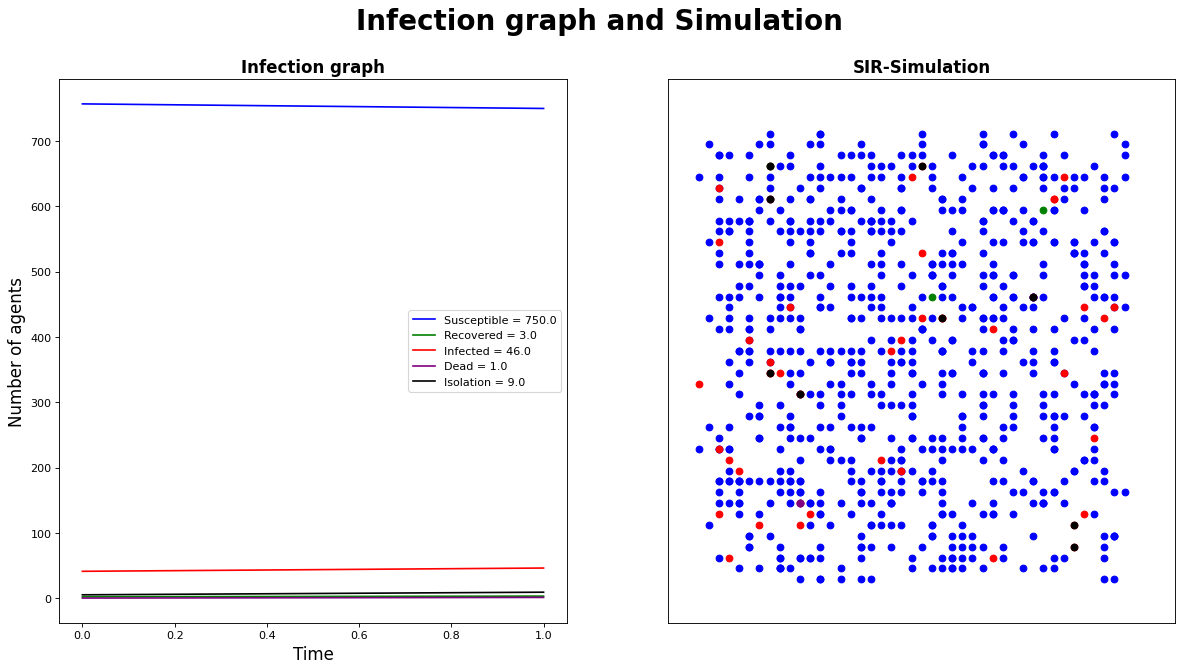

In [ ]:
#@title #Simulation paramaters { form-width: "500px", display-mode: "form" }

# order of the parameters in the list sent to run_sir():
# [number_of_agents, initially_infected, test_capacity, false_tests_prob,
#  infection_rate, recovery_rate, death_rate, death_rate_old_people, loss_of_immunity_prob,
#  lockdown_start_time, lockdown_duration,proportion_of_old_people, mutation_start_time,
#  new_infection_rate, new_recovery_rate, new_death_rate, new_death_rate_old_people,
#  new_loss_of_immunity_prob, neural_network_activated]
standard_values = [800,30,30,0,0.8,0.03,0.02,0.2,0,0,25,0,0,0,0,0,0,0,True]

#@markdown Standard simulation
standard_simulation = True #@param {type:"boolean"}



#@markdown Starting conditions
number_of_agents = 100 #@param {type:"slider", min:100, max:1000, step:50}
initially_infected = 5 #@param {type:"slider", min:5, max:500, step:5}

#@markdown Testing params
test_capacity = 5 #@param {type:"slider", min:5, max:100, step:5}
false_tests_prob = 0 #@param {type:"slider", min:0, max:1, step:0.02}

#@markdown Disease params
infection_rate = 0 #@param {type:"slider", min:0, max:1, step:0.02}
recovery_rate = 0 #@param {type:"slider", min:0, max:1, step:0.02}
death_rate = 0 #@param {type:"slider", min:0, max:1, step:0.02}
death_rate_old_people = 0 #@param {type:"slider", min:0, max:1, step:0.02}
loss_of_immunity_prob = 0 #@param {type:"slider", min:0, max:1, step:0.02}

#@markdown Lockdown params
lockdown_start_time = 0 #@param {type:"slider", min:0, max:250, step:25}
lockdown_duration = 25 #@param {type:"slider", min:25, max:200, step:25}

#@markdown Age params
proportion_of_old_people = 0 #@param {type:"slider", min:0, max:1, step:0.02}

#@markdown Mutation params
mutation_start_time = 0 #@param {type:"slider", min:0, max:250, step:25}
new_infection_rate = 0 #@param {type:"slider", min:0, max:1, step:0.02}
new_recovery_rate = 0 #@param {type:"slider", min:0, max:1, step:0.02}
new_death_rate = 0 #@param {type:"slider", min:0, max:1, step:0.02}
new_death_rate_old_people = 0 #@param {type:"slider", min:0, max:1, step:0.02}
new_loss_of_immunity_prob = 0 #@param {type:"slider", min:0, max:1, step:0.02}

#@markdown Neural network
neural_network_activated = False #@param {type:"boolean"}


if standard_simulation:
    running_values = standard_values
else:
    running_values = [number_of_agents, initially_infected, test_capacity, false_tests_prob,
    infection_rate, recovery_rate, death_rate, death_rate_old_people, loss_of_immunity_prob,
    lockdown_start_time, lockdown_duration,proportion_of_old_people, mutation_start_time,
    new_infection_rate, new_recovery_rate, new_death_rate, new_death_rate_old_people,
    new_loss_of_immunity_prob, neural_network_activated]

run_sir(running_values)